#**Parameter Analysis for the ARIMA model**

## Import the library


In [2]:
# To hide the output
%%capture
# To install the library
!pip install pmdarima

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Import the library
from pmdarima import auto_arima
from pmdarima.arima import ADFTest
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

## Read dataset

In [4]:
df = pd.read_csv('/content/traffic.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DateTime  48120 non-null  object
 1   Junction  48120 non-null  int64 
 2   Vehicles  48120 non-null  int64 
 3   ID        48120 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


## Test for Stationarity


In [7]:
adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(df['Vehicles'])

(0.01, False)

### Split the data

In [10]:
df_part = df.iloc[:500]
df_part.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [17]:
df_part.tail()

,DateTime,Junction,Vehicles,ID
495,2015-11-21 15:00:00,1,18,20151121151
496,2015-11-21 16:00:00,1,17,20151121161
497,2015-11-21 17:00:00,1,17,20151121171
498,2015-11-21 18:00:00,1,19,20151121181
499,2015-11-21 19:00:00,1,22,20151121191


### From the above, we can conclude that the data is non-stationary.

## Fit auto_arima function to AirPassengers dataset


In [11]:
stepwise_fit = auto_arima(df_part['Vehicles'], start_p = 1, start_q = 1,
                          max_p = 3, max_q = 3, m = 12,
                          start_P = 0, seasonal = True,
                          d = None, D = 1, trace = True,
                          error_action ='ignore',   # we don't want to know if an order does not work
                          suppress_warnings = True,  # we don't want convergence warnings
                          stepwise = True)           # set to stepwise

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=3.46 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=3727.520, Time=0.08 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=2737.006, Time=0.90 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=3.44 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=3725.624, Time=0.11 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=3056.391, Time=0.22 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=2734.580, Time=4.01 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=13.69 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.46 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=3217.879, Time=3.26 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=2702.995, Time=3.32 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=2704.180, Time=3.36 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=11.91 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=6.29 sec
 ARIMA(3,0,0)(2,1,0)[12] intercept   : AIC=2704

### From the above, we can see the best model is (2,0,0)(2,1,0)[12]

## To print the summary


In [12]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  500
Model:             SARIMAX(2, 0, 0)x(2, 1, 0, 12)   Log Likelihood               -1345.508
Date:                            Wed, 21 Aug 2024   AIC                           2701.016
Time:                                    08:45:13   BIC                           2721.968
Sample:                                         0   HQIC                          2709.246
                                            - 500                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5972      0.036     16.586      0.000       0.527       0.668
ar.L2          0.2684      0.036      7.385      0.000       0.197       0.340
ar.S.L12      -0.8060      0.040    -20.313      0.000      -0.884      -0.728
ar.S.L24      -0.0824      0.046     -1.776      0.076      -0.173       0.009
sigma2        14.2186      0.565     25.172      0.000      13.111      15.326
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               262.83
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.22   Skew:                             0.64
Prob(H) (two-sided):                  0.21   Kurtosis:                         6.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Fit ARIMA Model

## Split data into train / test sets


In [13]:
train = df.iloc[:len(df)-12]
test = df.iloc[len(df)-12:] # set one year(12 months) for testing

## Fit a SARIMAX(2, 0, 0)x(2, 1, 0, 12) on the training set


In [14]:
model = SARIMAX(train['Vehicles'],
                order = (2, 0, 0),
                seasonal_order =(2, 1, 0, 12))

In [15]:
result = model.fit()

In [16]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                           Vehicles   No. Observations:                48108
Model:             SARIMAX(2, 0, 0)x(2, 1, 0, 12)   Log Likelihood             -145998.999
Date:                            Wed, 21 Aug 2024   AIC                         292007.997
Time:                                    09:02:00   BIC                         292051.902
Sample:                                         0   HQIC                        292021.775
                                          - 48108                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7730      0.002    457.856      0.000       0.770       0.776
ar.L2          0.0874      0.002     45.137      0.000       0.084       0.091
ar.S.L12      -0.8202      0.003   -318.161      0.000      -0.825      -0.815
ar.S.L24      -0.1516      0.003    -58.380      0.000      -0.157      -0.146
sigma2        25.3572      0.038    665.153      0.000      25.282      25.432
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           3557886.72
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               1.27   Skew:                             1.65
Prob(H) (two-sided):                  0.00   Kurtosis:                        45.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Predictions of ARIMA Model against the test set

In [18]:
start = len(train)
end = len(train) + len(test) - 1

# Predictions for one-year against the test set
predictions = result.predict(start, end,
                             typ = 'levels').rename("Predictions")

## plot predictions and actual values



<Axes: >

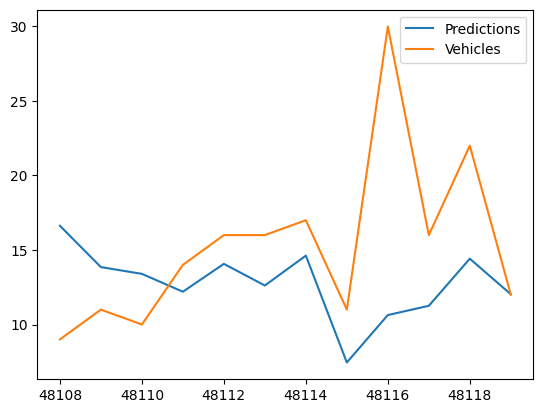

In [19]:
predictions.plot(legend = True)
test['Vehicles'].plot(legend = True)

## Evaluate the model using MSE and RMSE

In [21]:
# Calculate root mean squared error
rmse(test['Vehicles'], predictions)

# Calculate mean squared error
mean_squared_error(test['Vehicles'], predictions)

47.46297787581582

#**Well Done :)**